### Import

In [224]:
import sklearn
import numpy as np
import sklearn
import pickle
import sklearn.ensemble
import sklearn.metrics
import matplotlib.pyplot as plt

from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Fonts

In [255]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Load Data

In [225]:
data = pickle.load( open( "../../data/cancer_corpi/articles/pickle/processed.p","rb"))    

### Transform data

In [229]:
classes = []
y_names = []
X = []
for item in data['records']:
    label = item[-1]
    y_names.append(label)
    X.append(item[1])
X = np.expand_dims(np.array(X),-1)
y_names = np.expand_dims(np.array(y_names),-1)
classes = np.unique(y_names)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_names)
y = enc.transform(y_names).toarray()

### Count examples for class and restrict to 2 classes

In [230]:
counts = np.sum(y,axis=0)
idx1 = np.where(y_names == 'breast_cancer')[0]
idx2 = np.where(y_names == 'leukemia')[0]
mincount = np.min([len(idx1),len(idx2)])
idx1 = idx1[:mincount]
idx2 = idx2[:mincount]
idx = np.union1d(idx1,idx2)
# randperm = np.random.permutation(len(idx))
# idx = idx[randperm]
X = X[idx,:]
y = y[idx,:]
y = y[:,[0,2]]
classes = ['leukemia','beast_cancer']

### Divide into train and test

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Vectorize the text and get the vocabulary

In [232]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=1000)
train_vectors = vectorizer.fit_transform(X_train[:,0])
test_vectors = vectorizer.transform(X_test[:,0])
vocabulary = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names()

### Create Random Forest Classifier

In [233]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500);
rf.fit(train_vectors, y_train[:,0]);

### Predict

In [234]:
pred = rf.predict(test_vectors)
pred_prob = rf.predict_proba(test_vectors)
sklearn.metrics.f1_score(y_test[:,0], pred, average='binary')

0.9728915662650602

### Add the vectorizer ato the model pipeline

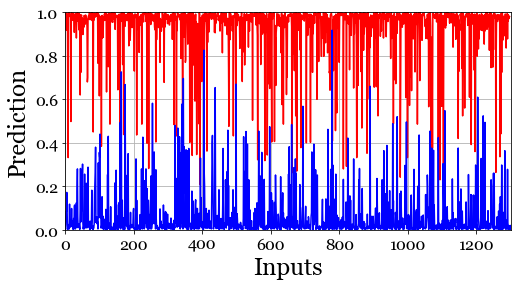

In [262]:
vector2model = make_pipeline(vectorizer, rf)
pred_prob = vector2model.predict_proba(X_test[:,0])
plt.figure(figsize=(8,4))
plt.plot(pred_prob[y_test[:,0] == 0][:,0],'r');
plt.plot(pred_prob[y_test[:,0] == 1][:,0],'b');
plt.grid();
plt.xlabel('Inputs',**csfont,fontsize=24);
plt.ylabel('Prediction',**csfont,fontsize=24);
plt.axis((0,y_test.shape[0]/2,0,1));
plt.xticks(**csfont,fontsize=16);
plt.yticks(**csfont,fontsize=16);

### Explainer

In [278]:
idx = 4
explainer = LimeTextExplainer(class_names=classes)
exp = explainer.explain_instance(X_test[idx,0], vector2model.predict_proba, num_features=6)
pred = vector2model.predict_proba([X_test[idx,0]])
print('Document id: %d' % idx)
print('Probability(breast cancer) =', pred[0][1])
print('Probability(leukemia) =', pred[0][0])
print('True class: %s' % classes[int(y_test[idx,0])])
print('')
features = exp.as_list()
for item in features:
    name,weight = item
    print(name + ' -> ' + str(weight))

Document id: 4
Probability(breast cancer) = 0.008
Probability(leukemia) = 0.992
True class: leukemia

leukaemia -> -0.029010579441991244
acute -> -0.02405933277998922
aml -> -0.01765025829221023
marrow -> -0.015933989541364647
myeloid -> -0.013434314954524039
health -> 0.009253537745234311


### Removing some features and recompute

In [269]:
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0,1])
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['breast']] = 0
tmp[0,vectorizer.vocabulary_['cancer']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(test_vectors[idx])[0,1])

Original prediction: 0.998
Prediction removing some features: 0.476
Difference: -0.522


In [198]:
y_pred = vector2model.predict(X_test[:,0])
print(np.sum(y_pred == y_test[:,0]))
len(y_test)

2532


2605

In [190]:
# c = make_pipeline(vectorizer, rf)
# print(c.predict_proba([newsgroups_test.data[0]]))
# [[ 0.274  0.726]]
# Now we create an explainer object. We pass the class_names a an argument for prettier display.

# from lime.lime_text import LimeTextExplainer
# explainer = LimeTextExplainer(class_names=class_names)
# We then generate an explanation with at most 6 features for an arbitrary document in the test set.

# idx = 83
# exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
# print('Document id: %d' % idx)
# print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
# print('True class: %s' % class_names[newsgroups_test.target[idx]])
# Document id: 83
# Probability(christian) = 0.414
# True class: atheism
# The classifier got this example right (it predicted atheism).
# The explanation is presented below as a list of weighted features.

# exp.as_list()
# [(u'Posting', -0.15748303818990594),
#  (u'Host', -0.13220892468795911),
#  (u'NNTP', -0.097422972255878093),
#  (u'edu', -0.051080418945152584),
#  (u'have', -0.010616558305370854),
#  (u'There', -0.0099743822272458232)]
# These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Roughly, if we remove 'Posting' and 'Host' from the document , the prediction should move towards the opposite class (Christianity) by about 0.27 (the sum of the weights for both features). Let's see if this is the case.


# Visualizing explanations
# The explanations can be returned as a matplotlib barplot:

# %matplotlib inline
# fig = exp.as_pyplot_figure()

# The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs.

# exp.show_in_notebook(text=False)
# Prediction probabilities
# 0.59
# atheism
# 0.41
# christian
# atheism
# christian
# Posting
# 0.16
# Host
# 0.13
# NNTP
# 0.10
# edu
# 0.05
# have
# 0.01
# There
# 0.01
# Alternatively, we can save the fully contained html page to a file:

# exp.save_to_file('/tmp/oi.html')
# Finally, we can also include a visualization of the original document, with the words in the explanations highlighted. Notice how the words that affect the classifier the most are all in the email header.

# exp.show_in_notebook(text=True)
# Prediction probabilities
# 0.59
# atheism
# 0.41
# christian
# atheism
# christian
# Posting
# 0.16
# Host
# 0.13
# NNTP
# 0.10
# edu
# 0.05
# have
# 0.01
# There
# 0.
# johnchad@triton.unm.edu
# or
# That's it for this tutorial. Random forests were just an example, this explainer works for any classifier you may want to use, as long as it implements predict_proba.